In [160]:
# The following two commands remove any previously installed H2O packages for R.
#if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
#if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }
# Let's download packages that H2O depends on.
#if (! ("methods" %in% rownames(installed.packages()))) { install.packages("methods") }
#if (! ("statmod" %in% rownames(installed.packages()))) { install.packages("statmod") }
#if (! ("stats" %in% rownames(installed.packages()))) { install.packages("stats") }
#if (! ("graphics" %in% rownames(installed.packages()))) { install.packages("graphics") }
#if (! ("RCurl" %in% rownames(installed.packages()))) { install.packages("RCurl") }
#if (! ("jsonlite" %in% rownames(installed.packages()))) { install.packages("jsonlite") }
#if (! ("tools" %in% rownames(installed.packages()))) { install.packages("tools") }
#if (! ("utils" %in% rownames(installed.packages()))) { install.packages("utils") }
# Download, install and initialize the H2O package for R.
#install.packages("h2o", type="source", 
#                 repos=(c("http://h2o-release.s3.amazonaws.com/h2o/rel-turing/10/R")))
# Test, if the H2O library is installed properly
#suppressPackageStartupMessages(library(h2o))
#h2o.init(nthreads = -1)
# Finally, let's run a demo on K-means clustering to see H2O at work.
#demo(h2o.kmeans)

In [2]:
library(h2o)
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         12 seconds 33 milliseconds 
    H2O cluster version:        3.10.0.10 
    H2O cluster version age:    8 months and 13 days !!! 
    H2O cluster name:           H2O_started_from_R_bhara_cql266 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.74 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 


Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (8 months and 13 days)!
Please download and install the latest version from http://h2o.ai/download/"

In [95]:
mtcar <- read.csv("C:\\DCU\\Main\\full_datasets\\fact_price_monthly_dairy.csv",header=T,stringsAsFactors=FALSE)
mtcar$geo <- as.factor(mtcar$geo)  
mtcar$unit <- as.factor(mtcar$unit) 
mtcar$product <- as.factor(mtcar$product)  
mtcar$source  <- as.factor(mtcar$source)  
mtcar$price  <- as.numeric(mtcar$price)
mtcar$price[is.na(mtcar$price)] = mean(mtcar$price, na.rm=TRUE)
mtcar$price <-as.numeric(mtcar$price)
mtcar.hex  <- as.h2o(mtcar)

Warning message in as.numeric(mtcar$price):
"NAs introduced by coercion"

  |======================================================================| 100%


In [122]:
mtcar.hex

      id yearmonth   geo   unit product    price           source
1 291650    201712 CHINA EUR/kg    milk 1.448498 clal_dairy_price
2 291649    201711 CHINA EUR/kg    milk 1.448498 clal_dairy_price
3 291648    201710 CHINA EUR/kg    milk 1.448498 clal_dairy_price
4 291647    201709 CHINA EUR/kg    milk 1.448498 clal_dairy_price
5 291646    201708 CHINA EUR/kg    milk 1.448498 clal_dairy_price
6 291645    201707 CHINA EUR/kg    milk 1.448498 clal_dairy_price

[6530 rows x 7 columns] 

In [104]:
mtcar.dl = h2o.deeplearning(x = 1:7, training_frame = mtcar.hex, autoencoder = TRUE,activation="Tanh",
                            hidden = c(50, 50, 50), epochs = 100,seed=1)

  |======================================================================| 100%


In [105]:
errors <- h2o.anomaly(mtcar.dl, mtcar.hex, per_feature = TRUE)

In [107]:
anomalies <- as.data.frame(errors)

In [156]:
quantile  = h2o.quantile(errors$reconstr_price.SE)
threshold = quantile["99%"]
#print(threshold)
#plot(anomalies$reconstr_price.SE)
#abline(h=threshold)

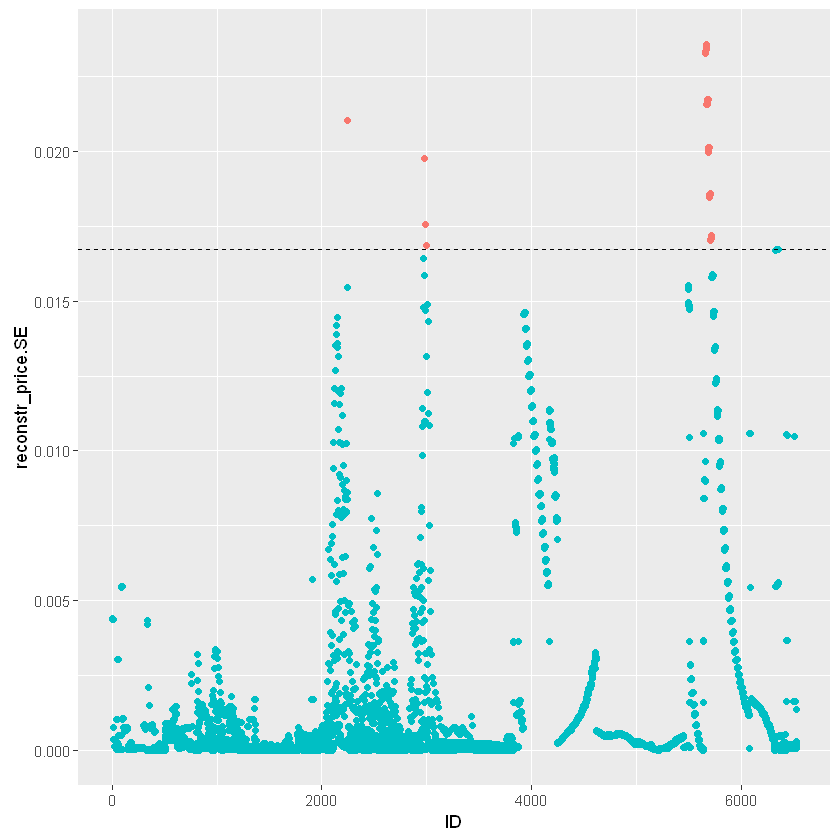

In [157]:
library(ggplot2)
anomalies$ID <- seq.int(nrow(anomalies))
a <- ggplot(anomalies, aes(x=ID,y=reconstr_price.SE, color=ifelse((reconstr_price.SE> threshold),"blue", "red")))+
    geom_point()+
    geom_hline(yintercept=threshold, linetype="dashed", color = "black")

a + theme(legend.position="none")

In [158]:
row_outliers <- which(anomalies$reconstr_price.SE > threshold) # based on plot above
anomalous_instances <- mtcar[row_outliers,]

In [159]:
head(anomalous_instances)

,id,yearmonth,geo,unit,product,price,source
2248,272942,201304,OCEANIA,USD/kg,SMP,5.3938000,dairyco_world_price
2980,272210,200709,EU,USD/kg,WMP,5.6000000,dairyco_world_price
2992,272198,200708,EU,USD/kg,SMP,5.3167000,dairyco_world_price
3002,272188,200707,EU,USD/kg,WMP,5.4500000,dairyco_world_price
5662,27745,198012,UNITED STATES,USD/kg,MILK - PRICE RECEIVED- MEASURED IN $ / CWT,0.2775465,usda_dairy_quickstats
5663,27744,198011,UNITED STATES,USD/kg,MILK - PRICE RECEIVED- MEASURED IN $ / CWT,0.2755781,usda_dairy_quickstats
